# Exploring time varying dynamics

## Importing the necessary modules

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np #numerical python used for working with arrays, mathematical operations
import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays

import sys
usernm = "rmcgorty"
sys.path.append("C:/Users/%s/Documents/GitHub/PyDDM/PyDDM" % usernm) #must point to the PyDDM folder
### If you don't have PyDDM, get it here: https://github.com/rmcgorty/PyDDM
import ddm_analysis_and_fitting as ddm

import pickle #for saving data

## Example data -- 1 micron beads with stage moving at 7 microns/s

In [2]:
import yaml
ddm_analysis_parameters_str = """
DataDirectory: './'
FileName: '1um_Beads_7ums.tif'
Metadata:
  pixel_size: 0.186 # size of pixel in um
  frame_rate: 45.4 #frames per second
  channel: 0
Analysis_parameters:
  starting_frame_number: 0
  number_lag_times: 30
  last_lag_time: 600
  binning: no
  bin_size: 2
  use_windowing_function: no
Fitting_parameters:
  model: 'DDM Matrix - Single Exponential'
  Tau: [1.0, 0.001, 10]
  StretchingExp: [1.0, 0.5, 3.1]
  Amplitude: [1e2, 1, 1e6]
  Background: [2.5e4, 0, 1e7]
  Good_q_range: [5, 20]
  Auto_update_good_q_range: True
"""
parameters_as_dictionary = yaml.safe_load(ddm_analysis_parameters_str)
ddm_calc = ddm.DDM_Analysis(parameters_as_dictionary)

Provided metadata: {'pixel_size': 0.186, 'frame_rate': 45.4, 'channel': 0}
Image shape: 2000-by-128-by-128
Number of frames to use for analysis: 2000
Maximum lag time (in frames): 600
Number of lag times to compute DDM matrix: 30
Using the full frame, dimensions: 128-by-128.


In [3]:
dt = 1 #lag time (in frames)
sz = 4 #size of the region of the matrix of phases over which to fit a plane
phiDM = ddm_calc.phiDM(dt, sz, use_gf=True, gfsize=3, err_limit=2e-5)

phiDM.to_netcdf("phiDM_%s_dt%i_size%i.nc" % (ddm_calc.filename_for_saving_data, dt,sz)) #save to disk

With error threshold, magntiude of v = 5.927
Vx +/- stderr = -5.927 +/- 0.091
Vy +/- stderr = -0.032 +/- 0.089
Vx std deviation = 2.458
Vy std deviation = 2.397
Skew vx: 0.042
Skew vy: 0.028
median Vx +/- stderr = -5.951 +/- 0.091
median Vy +/- stderr = -0.092 +/- 0.089


Text(0, 0.5, 'Counts')

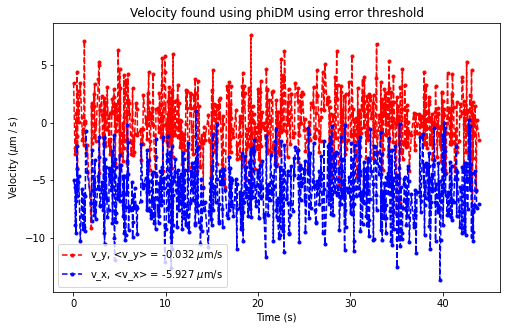

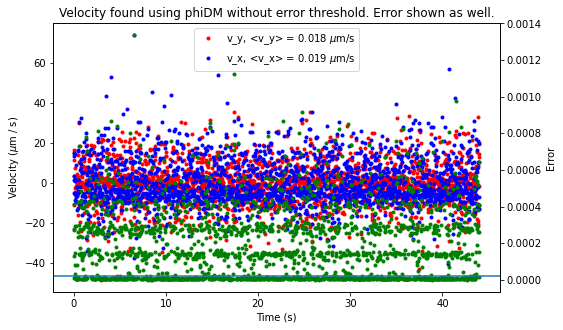

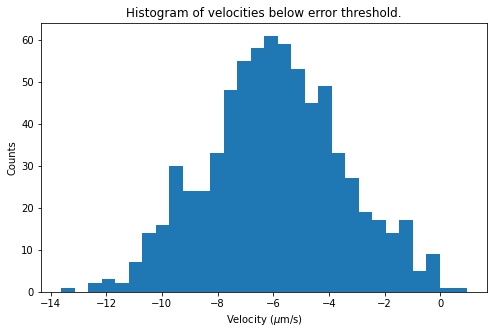

In [4]:
fig,ax = plt.subplots(figsize=(8,8/1.618))

#Locate where the error is less than some limit
w = np.where(phiDM.error < phiDM.err_limit)

ax.plot(phiDM.vtime[w], phiDM.vy[w], '--r.', label='v_y, <v_y> = %.3f $\mu$m/s' % np.mean(phiDM.vy[w]))
ax.plot(phiDM.vtime[w], phiDM.vx[w], '--b.', label='v_x, <v_x> = %.3f $\mu$m/s' % np.mean(phiDM.vx[w]))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Velocity ($\mu$m / s)")
plt.legend(loc=0)
ax.set_title("Velocity found using phiDM using error threshold")
print("With error threshold, magntiude of v = %.3f" % np.sqrt(np.mean(phiDM.vy[w])**2 + np.mean(phiDM.vx[w])**2))
print("Vx +/- stderr = %.3f +/- %.3f" % (np.mean(phiDM.vx[w]),np.std(phiDM.vx[w])/np.sqrt(len(w[0]))))
print("Vy +/- stderr = %.3f +/- %.3f" % (np.mean(phiDM.vy[w]),np.std(phiDM.vy[w])/np.sqrt(len(w[0]))))
print("Vx std deviation = %.3f" % np.std(phiDM.vx[w]))
print("Vy std deviation = %.3f" % np.std(phiDM.vy[w]))

skew_vx = np.mean(((phiDM.vx[w] - phiDM.vx[w].mean())**3)/ phiDM.vx[w].std()**3)
print("Skew vx: %.3f" % skew_vx)
skew_vy = np.mean(((phiDM.vy[w] - phiDM.vy[w].mean())**3)/ phiDM.vy[w].std()**3)
print("Skew vy: %.3f" % skew_vy)

print("median Vx +/- stderr = %.3f +/- %.3f" % (np.median(phiDM.vx[w]),np.std(phiDM.vx[w])/np.sqrt(len(w[0]))))
print("median Vy +/- stderr = %.3f +/- %.3f" % (np.median(phiDM.vy[w]),np.std(phiDM.vy[w])/np.sqrt(len(w[0]))))

fig,ax = plt.subplots(figsize=(8,8/1.618))
ax.set_title("Velocity found using phiDM without error threshold. Error shown as well.")
ax2 = ax.twinx()
w = np.where(phiDM.error < phiDM.err_limit)
ax.plot(phiDM.vtime, phiDM.vy, 'r.', label='v_y, <v_y> = %.3f $\mu$m/s' % np.mean(phiDM.vy))
ax.plot(phiDM.vtime, phiDM.vx, 'b.', label='v_x, <v_x> = %.3f $\mu$m/s' % np.mean(phiDM.vx))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Velocity ($\mu$m / s)")
ax2.plot(phiDM.vtime, phiDM.error,'g.')
ax2.axhline(y=phiDM.err_limit)
ax2.set_ylabel("Error")
ax.legend(loc=0)

fig,ax = plt.subplots(figsize=(8,8/1.618))
w = np.where(phiDM.error < phiDM.err_limit)
ax.set_title("Histogram of velocities below error threshold.")
ax.hist(phiDM.vx[w], bins=30)
ax.set_xlabel("Velocity ($\mu$m/s)")
ax.set_ylabel("Counts")

## Can we correct for this simulated drift and just get Brownian motion?

The file ./1um_Beads_7ums_c=0_ddmmatrix.nc already exists. So perhaps the DDM matrix was calculated already?
Do you still want to calculate the DDM matrix? (y/n): y


2022-06-10 14:13:37,046 - DDM Calculations - Running dt = 1...


Will run DDM computation to correct for velocity...
[7, 0]


2022-06-10 14:13:47,639 - DDM Calculations - Running dt = 5...
2022-06-10 14:13:52,800 - DDM Calculations - Running dt = 11...
2022-06-10 14:13:55,156 - DDM Calculations - Running dt = 24...
2022-06-10 14:13:56,302 - DDM Calculations - Running dt = 51...
2022-06-10 14:13:56,866 - DDM Calculations - Running dt = 110...
2022-06-10 14:13:57,120 - DDM Calculations - Running dt = 234...
2022-06-10 14:13:57,252 - DDM Calculations - Running dt = 497...


DDM matrix took 20.24392819404602 seconds to compute.
 Background estimate ± std is 46.05 ± 0.58


<xarray.Dataset>
Dimensions:           (lagtime: 30, q_y: 128, q_x: 128, q: 64, y: 128, x: 128, frames: 30)
Coordinates:
  * lagtime           (lagtime) float64 0.02203 0.04405 0.06608 ... 10.95 13.19
    framelag          (frames) int32 1 2 3 4 5 6 7 ... 234 282 341 411 497 599
  * q_y               (q_y) float64 -16.89 -16.63 -16.36 ... 16.1 16.36 16.63
  * q_x               (q_x) float64 -16.89 -16.63 -16.36 ... 16.1 16.36 16.63
  * q                 (q) float64 0.0 0.2639 0.5278 0.7917 ... 16.1 16.36 16.63
  * y                 (y) int32 0 1 2 3 4 5 6 7 ... 121 122 123 124 125 126 127
  * x                 (x) int32 0 1 2 3 4 5 6 7 ... 121 122 123 124 125 126 127
Dimensions without coordinates: frames
Data variables:
    ddm_matrix_full   (lagtime, q_y, q_x) float64 44.11 30.9 ... 54.12 47.78
    ddm_matrix        (lagtime, q) float64 0.0 598.2 743.4 ... 48.0 45.94 46.99
    first_image       (y, x) float64 201.0 199.0 198.0 ... 173.0 179.0 182.0
    alignment_factor  (lagtime, q) float64 nan 6.123e-17 ... 0.04557 0.04188
    avg_image_ft      (q) float64 0.0 1.795e+05 1.168e+05 ... 23.01 22.55 22.92
    num_pairs_per_dt  (lagtime) int32 1999 1998 1997 998 998 ... 19 15 12 10 8
    B                 float64 46.05
    B_std             float64 0.5786
    Amplitude         (q) float64 -46.05 3.589e+05 2.335e+05 ... -0.9414 -0.2186
    ISF               (lagtime, q) float64 0.0 0.9985 0.997 ... 0.8847 5.312
Attributes: (12/20)
    units:                   Intensity
    lagtime:                 sec
    q:                       μm$^{-1}$
    x:                       pixels
    y:                       pixels
    info:                    ddm_matrix is the averages of FFT difference ima...
    ...                      ...
    starting_frame_number:   0
    number_lag_times:        30
    last_lag_time:           600
    binning:                 False
    bin_size:                2
    use_windowing_function:  False

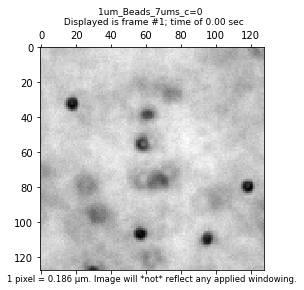

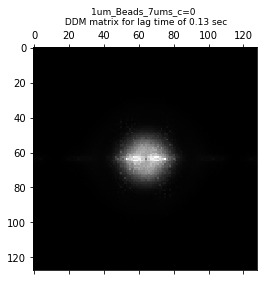

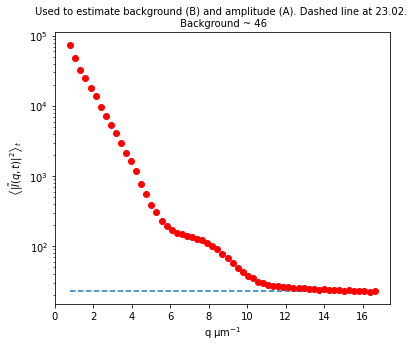

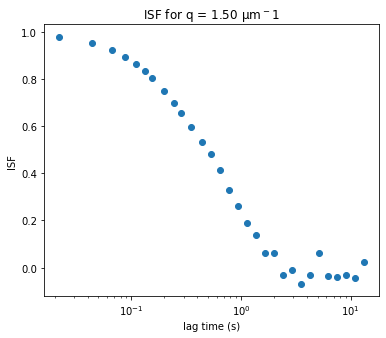

In [9]:
ddm_calc.calculate_DDM_matrix(velocity=[7,0])

,Initial guess,Minimum,Maximum
Amplitude,100.0,1.000,1000000.0
Tau,1.0,0.001,10.0
Background,25000.0,0.000,10000000.0
StretchingExp,1.0,0.500,3.1


File ./1um_Beads_7ums_ddmmatrix.nc not found.
Perhaps you meant to load one of...
	.\1um_Beads_7ums_c=0_ddmmatrix.nc
By default, loading .\1um_Beads_7ums_c=0_ddmmatrix.nc
In function 'get_tau_vs_q_fit', using new tau...
Fit is saved in fittings dictionary with key 'fit01'.
In function 'get_tau_vs_q_fit', using new tau...
In hf.plot_one_tau_vs_q function, using new tau... 


<xarray.Dataset>
Dimensions:          (parameter: 4, q: 64, lagtime: 30)
Coordinates:
  * parameter        (parameter) <U13 'Amplitude' 'Tau' ... 'StretchingExp'
  * q                (q) float64 0.0 0.2639 0.5278 0.7917 ... 16.1 16.36 16.63
  * lagtime          (lagtime) float64 0.02203 0.04405 0.06608 ... 10.95 13.19
Data variables:
    parameters       (parameter, q) float64 1.0 3.996e+05 2.477e+05 ... 3.1 1.56
    theory           (lagtime, q) float64 5.796e-09 460.7 851.9 ... 43.44 45.07
    isf_data         (lagtime, q) float64 0.0 0.9985 0.997 ... 0.8847 5.312
    ddm_matrix_data  (lagtime, q) float64 0.0 598.2 743.4 ... 48.0 45.94 46.99
    A                (q) float64 -46.05 3.589e+05 2.335e+05 ... -0.9414 -0.2186
    B                float64 46.05
Attributes: (12/18)
    model:                          DDM Matrix - Single Exponential
    data_to_use:                    DDM Matrix
    initial_params_dict:            ["{'n': 0, 'value': 100.0, 'limits': [1.0...
    effective_diffusion_coeff:      0.5993532331999998
    tau_vs_q_slope:                 [-1.91043178]
    msd_alpha:                      [1.04688376]
    ...                             ...
    DataDirectory:                  ./
    FileName:                       1um_Beads_7ums.tif
    pixel_size:                     0.186
    frame_rate:                     45.4
    BackgroundMethod:               0
    OverlapMethod:                  2

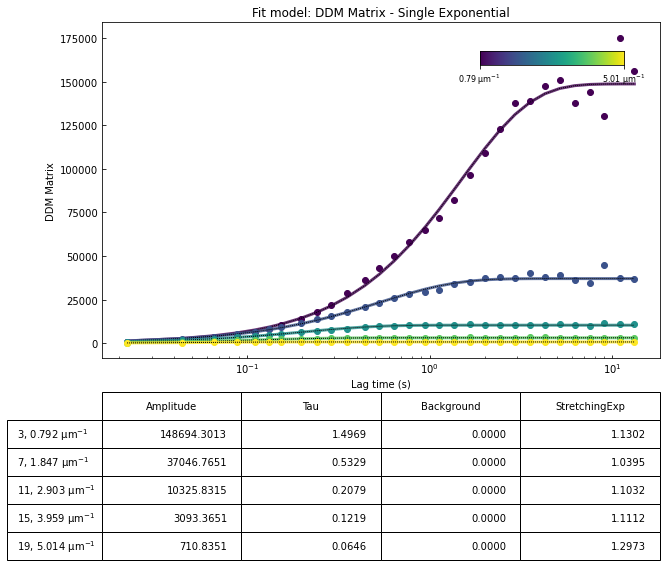

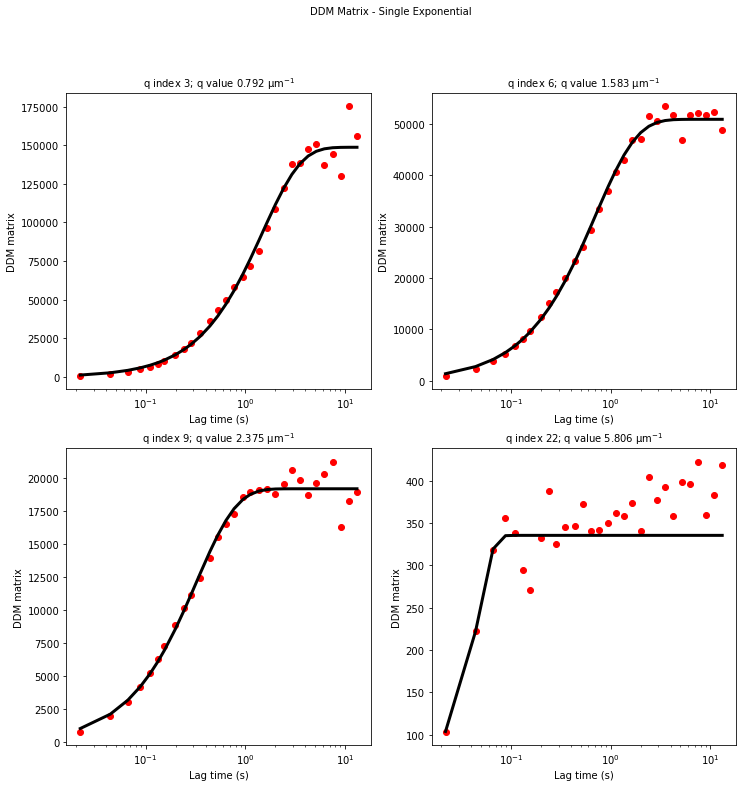

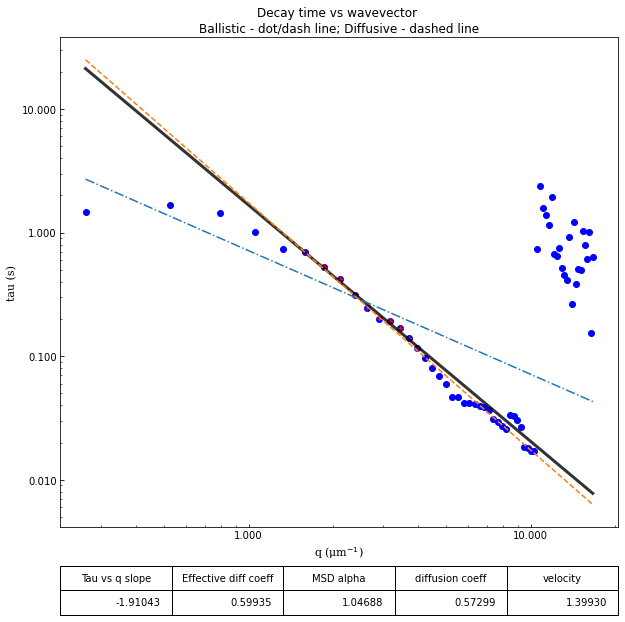

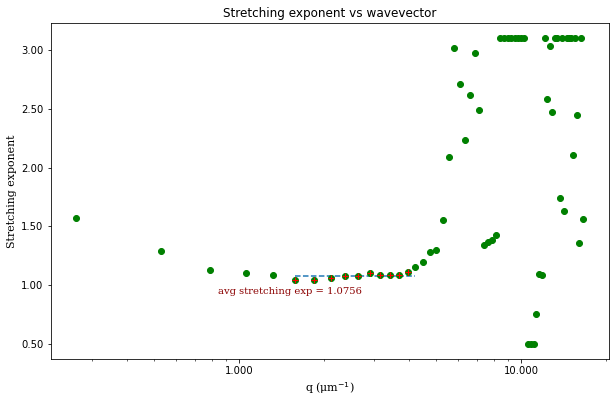

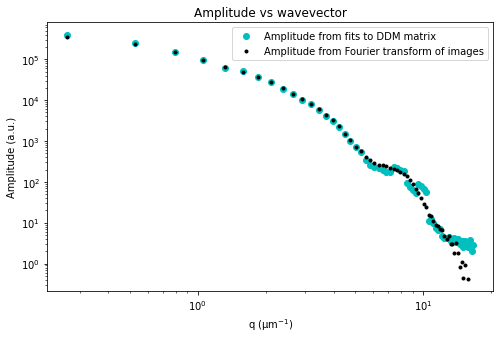

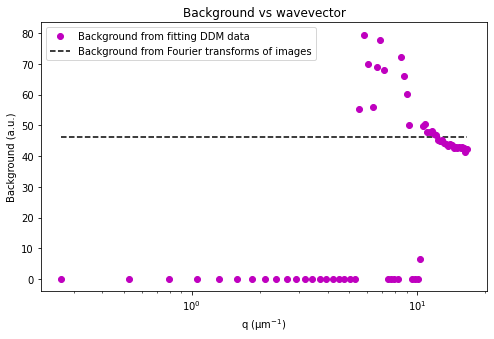

In [11]:
ddm_fit = ddm.DDM_Fit(parameters_as_dictionary)
fit01 = ddm_fit.fit(name_fit = 'fit01', display_table=False)
ddm.fit_report(fit01, q_indices=[3,6,9,22], forced_qs=[6,16], use_new_tau=True, show=True)